# Aplicando Python para análisis de precios: probabilidad precio-umbral

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://c2.staticflickr.com/4/3673/9761565422_8da861e1c8_b.jpg" width="400px" height="125px" />

> Ya habíamos visto como importar precios de cierre de acciones desde Yahoo Finance con la libreria `pandas-datareader`. En la clase pasada, además, vimos como pronosticar escenarios de evolución de precios suponiendo que los rendimientos diarios distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Descargando datos, una vez más

Recordamos una vez más como descargar los precios de cierre ajustados desde yahoo finance. 

Esta vez haremos una función.

In [41]:
# Importamos librerías
import numpy as np
import pandas as pd
import pandas_datareader as data
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Creamos la función
def load_adj_close(ticker, data_source, start_date, end_date):
    panel_data = data.DataReader(ticker, data_source, start_date, end_date)
    closes = panel_data.loc['Adj Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date)
    closes = closes.reindex(all_weekdays)
    closes = closes.fillna(method='ffill')
    return closes

In [43]:
# Descargamos datos de microsoft en el 2016
ticker = ['NVDA']
data_source = 'yahoo'
start_date = '2016-01-04'
end_date = '2016-12-31'
closes = load_adj_close(ticker, data_source, start_date, end_date)

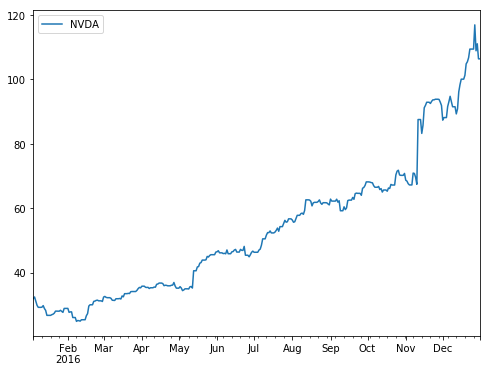

In [44]:
# Grafiquemos
closes.plot(figsize=(8,6));

## 2. Proyección de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Los rendimientos diarios se pueden calcular con los precios de cierre de la siguiente manera:

$$r_i=\frac{p_i-p_{i-1}}{p_{i-1}},$$

donde $r_i$ es el rendimiento en el día $i$ y $p_i$ es el precio de cierre ajustado en el día $i$.

En la clase pasada, vimos que una buena aproximación de la anterior expresión es:

$$r_i=\frac{p_i-p_{i-1}}{p_{i-1}}\approx \ln\left(\frac{p_i}{p_{i-1}}\right).$$

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [45]:
# Función que devuelve rendimientos diarios, media y desviación estándar
def mu_std_daily_ret(closes):
    daily_returns = (np.log(closes/closes.shift(1)))[1:]
    mu = daily_returns.mean().values[0]
    sigma = daily_returns.std().values[0]
    return daily_returns, mu, sigma

In [46]:
# Calculamos con la función anterior
daily_returns, mu, sigma = mu_std_daily_ret(closes)
mu, sigma

(0.0033224614879625229, 0.023412153511648267)

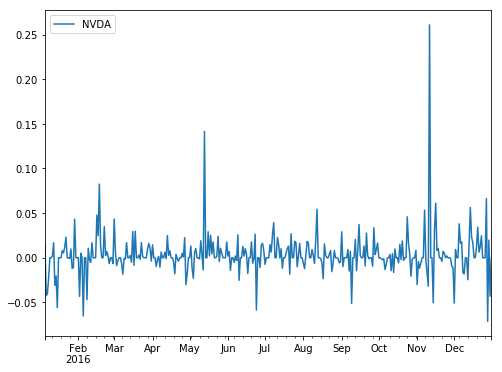

In [47]:
# Graficamos rendimientos diarios
daily_returns.plot(figsize=(8,6));

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2017 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios rendimientos diarios y que devuelva un dataframe con esta simulación.

In [49]:
# Función que simula varios escenarios de rendimientos diarios
def daily_ret_sim(mu, sigma, ndays, ntraj, start_date):
    dates = pd.date_range(start=start_date,periods=ndays)
    return pd.DataFrame(sigma*np.random.randn(ndays, ntraj)+mu, index = dates)

In [50]:
# Simulamos 100 escenarios para todo el 2017
ndays = 360
ntraj = 100
start_date = '2017-01-01'
simret = daily_ret_sim(mu, sigma, ndays, ntraj, start_date)

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}\exp(r_i)\\
p_{i+1}&=p_i\exp(r_{i+1})=p_{i-1}\exp(r_i)\exp(r_{i+1})=p_{i-1}\exp(r_i+r_{i+1})\\
&\vdots\\
p_{i+k}&=p_{i-1}\exp(r_i+\cdots+r_{i+k}).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}\exp(r_0+\cdots+r_{k})$, donde $p_{-1}$ es el último precio reportado en el 2016.

In [60]:
# Función de proyección de precios
def closes_proj(simret, closes):
    return (closes.iloc[-1,:].values[0])*np.exp(simret.cumsum())

In [61]:
# Proyección de precios y concatenación con precios de 2016
simdata = closes_proj(simret, closes)
simdata

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-01,104.290091,108.133138,109.782872,107.134501,107.764632,103.288117,106.081068,103.293452,105.876880,108.835401,...,106.128762,107.938030,104.842949,103.745600,104.719794,104.934434,107.232697,110.253253,109.490259,107.185351
2017-01-02,108.429917,109.228866,112.682909,103.465173,108.165405,105.545818,107.567778,102.582912,103.879160,108.141670,...,107.680695,107.340054,110.253249,104.006348,107.654150,105.428341,109.324474,111.239419,110.954130,106.184627
2017-01-03,109.356456,109.506211,113.948346,103.422131,113.668405,105.513740,110.228045,103.043146,102.140979,110.947842,...,107.068222,105.237981,115.288563,103.158922,112.193367,105.946107,105.529665,113.873721,112.107024,109.188058
2017-01-04,107.293919,108.639507,113.769500,102.682859,117.881947,103.726287,106.502662,103.860961,103.557860,109.058185,...,109.409791,104.256522,113.312269,100.521327,113.896108,103.467446,105.059237,109.570771,108.594093,109.381646
2017-01-05,107.137285,110.950648,111.447005,101.763697,117.697896,106.469226,108.688798,106.377002,103.911685,111.615541,...,114.167637,103.457086,112.668608,100.223725,118.354830,102.034944,106.767514,109.961151,108.153160,112.426606
2017-01-06,108.443659,110.668723,107.165044,101.917733,120.047096,109.570144,105.845417,109.714327,109.995856,114.428665,...,110.977893,100.825000,112.765111,99.177369,121.925202,100.109656,108.483369,112.232154,110.288365,118.203293
2017-01-07,110.277489,109.652355,110.074629,100.679759,122.585070,109.045113,102.274081,103.050137,109.174788,116.123892,...,110.496118,102.040956,111.872469,103.912950,118.445791,100.512453,109.624488,110.793830,112.080899,119.920860
2017-01-08,110.732139,108.818133,109.815351,98.614682,119.096748,107.916693,104.943449,102.350502,103.738982,114.604120,...,109.664644,100.960139,109.481213,108.168359,120.174711,96.955309,107.998814,112.022421,113.126861,118.559203
2017-01-09,113.763875,110.447617,113.983039,99.160134,117.957050,109.881454,102.806656,103.336208,99.580678,115.600827,...,112.549827,99.559574,105.970866,109.962491,120.966268,95.856206,109.465870,112.393894,111.919839,121.144890
2017-01-10,109.003115,109.568875,115.022221,99.309824,121.115297,108.560510,103.938943,102.827972,98.660738,117.656812,...,116.208373,100.372567,111.074638,108.666639,117.512674,97.931461,110.719513,117.880358,110.749903,123.887768


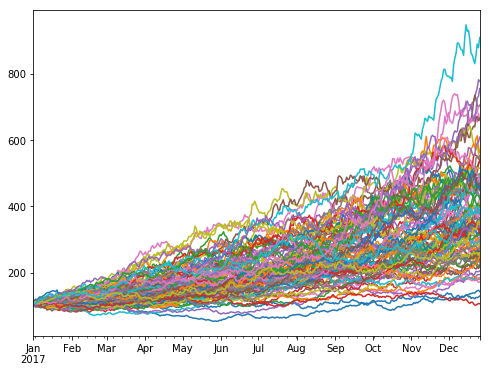

In [63]:
# Gráfico
simdata.plot(figsize=(8,6),legend=False);

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

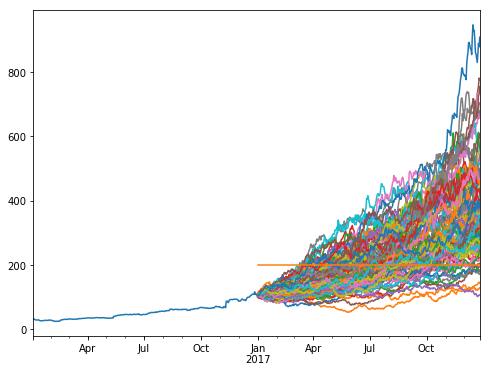

In [64]:
K = 200
dates = pd.date_range('20170101',periods=ndays)
strike = pd.DataFrame({'Strike':K*np.ones(ndays)},index=dates)
simul = pd.concat([closes.T,simdata.T,strike.T]).T
simul.plot(figsize=(8,6),legend=False);

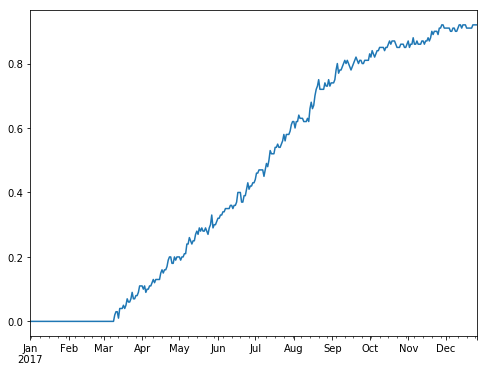

In [65]:
strike = pd.DataFrame(K*np.ones(ndays*ntraj).reshape((ndays,ntraj)),index=dates)
count = simdata>strike
prob = count.T.sum()/ntraj
prob.plot(figsize=(8,6),legend=False);

In [67]:
((K-closes.iloc[-1,:])/closes.iloc[-1,:]).values

array([ 0.87970596])

In [66]:
closes.iloc[-1,:]

NVDA    106.39962
Name: 2016-12-31 00:00:00, dtype: float64

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

## Recordar... Clase de reposición: mañana Miércoles 18 de Octubre de 16:00-18:00, aula D-206 (Clase de repaso).

1. Viernes 28 de Octubre y Martes 21 de Noviembre no hay clase.
2. Clase de reposición: mañana Miércoles 18 de Octubre de 16:00-18:00, aula D-206 (Clase de repaso).
3. Para el próximo viernes: proyecto definido, subir a moodle un cuaderno con nombre del proyecto, objetivos y una breve introducción.
4. Tarea la pongo hoy o mañana en la noche.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>